In [ ]:
# !pip install -qq torchmetrics torchinfo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as T
from torchmetrics.classification import Accuracy, ConfusionMatrix
from torchinfo import summary

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.Linear(in_features=4096, out_features=128),
            nn.BatchNorm1d(num_features=128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.LazyLinear(num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
summary(CNN(num_classes=10), input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─LeakyReLU: 2-3                    [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 16, 16]           9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 16, 16]           64
│    └─LeakyReLU: 2-6                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 16, 16]           128
│    └─LeakyReLU: 2-9                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-10                      [1, 64, 8, 8]             36,928
│    └─BatchNorm2d: 2-11                 [1, 64, 8, 8]             128
│

cuda
Train: 50000
Val  : 2000
Test : 8000
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


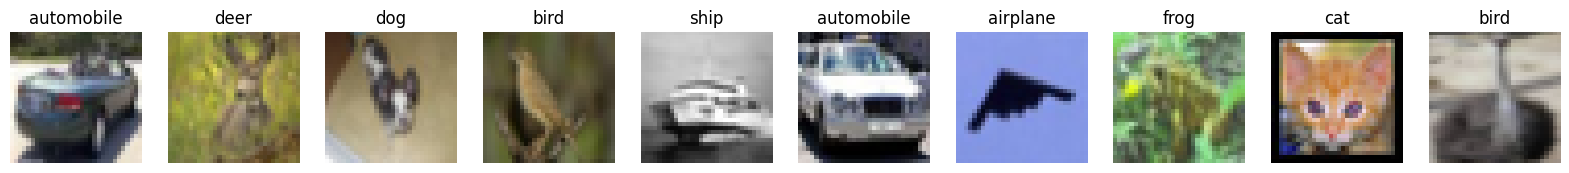

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Dataset
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.ToPureTensor(),
])

dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_val = int(len(dataset_test)*0.2)
n_test = len(dataset_test) - n_val

dataset_test, dataset_val = torch.utils.data.random_split(dataset_test, [n_test, n_val], generator=torch.Generator().manual_seed(42))
print(f"Train: {len(dataset_train)}")
print(f"Val  : {len(dataset_val)}")
print(f"Test : {len(dataset_test)}")

id2cls = {i: cls for i, cls in enumerate(dataset_train.classes)}
print(id2cls)

n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(dataset_val[i][0].permute(1, 2, 0))
    plt.title(id2cls[dataset_val[i][1]])
    plt.axis("off")

plt.show()

In [ ]:
# DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

# Model, Optimizer, Criterion
model = CNN(num_classes=10)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# Metrics
accuracy_train = Accuracy(task="multiclass", num_classes=10)
accuracy_train = accuracy_train.to(device)
accuracy_val = Accuracy(task="multiclass", num_classes=10)
accuracy_val = accuracy_val.to(device)

metrics = {
    "train": {"loss": [], "accuracy": []},
    "val": {"loss": [], "accuracy": []},
}

# Results directory
results_dir = Path("results-cnn")
results_dir.mkdir(exist_ok=True, parents=True)

# Training loop
best_accuracy = 0
n_epochs = 5
for epoch in range(n_epochs):
    # Training
    model.train()

    loss_train = 0

    tqdm_train = tqdm(dataloader_train)
    tqdm_train.set_description("Epoch {:2d} (Train)".format(epoch))
    for batch in tqdm_train:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        acc = accuracy_train(preds, labels)
        loss_train += loss.item()

    loss_train = loss_train / len(dataloader_train)
    acc_train = accuracy_train.compute()
    accuracy_train.reset()

    print("(Train) loss {:.4f}, accuracy {:.4f}".format(loss_train, acc_train))
    metrics["train"]["loss"].append(loss_train)
    metrics["train"]["accuracy"].append(acc_train.item())

    torch.save(model.state_dict(), results_dir/"last.pth")

    # Validation
    model.eval()

    loss_val = 0

    tqdm_val = tqdm(dataloader_val)
    tqdm_val.set_description("Epoch {:2d} (Val)  ".format(epoch))
    for batch in tqdm_val:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(images)
            loss = criterion(logits, labels)

            preds = torch.argmax(logits, dim=1)
            accuracy_val.update(preds, labels)
            loss_val += loss.item()

    loss_val = loss_val / len(dataloader_val)
    acc_val = accuracy_val.compute()
    accuracy_val.reset()

    print("(Val)   loss {:.4f}, accuracy {:.4f}".format(loss_val, acc_val), end="\n\n")
    metrics["val"]["loss"].append(loss_val)
    metrics["val"]["accuracy"].append(acc_val.item())

    if acc_val > best_accuracy:
        best_accuracy = acc_val
        torch.save(model.state_dict(), results_dir/"best.pth")

Epoch  0 (Train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch  0 (Train): 100%|██████████| 782/782 [00:11<00:00, 69.30it/s]


(Train) loss 1.3582, accuracy 0.5166


Epoch  0 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 92.75it/s]


(Val)   loss 1.0615, accuracy 0.6165



Epoch  1 (Train): 100%|██████████| 782/782 [00:10<00:00, 72.36it/s]


(Train) loss 0.9932, accuracy 0.6551


Epoch  1 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 90.78it/s]


(Val)   loss 0.8719, accuracy 0.6860



Epoch  2 (Train): 100%|██████████| 782/782 [00:10<00:00, 72.39it/s]


(Train) loss 0.8367, accuracy 0.7074


Epoch  2 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 87.53it/s]


(Val)   loss 0.8527, accuracy 0.6910



Epoch  3 (Train): 100%|██████████| 782/782 [00:10<00:00, 73.90it/s]


(Train) loss 0.7354, accuracy 0.7437


Epoch  3 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 86.43it/s]


(Val)   loss 0.8100, accuracy 0.7135



Epoch  4 (Train): 100%|██████████| 782/782 [00:10<00:00, 74.15it/s]


(Train) loss 0.6581, accuracy 0.7707


Epoch  4 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 92.92it/s]

(Val)   loss 0.7562, accuracy 0.7415



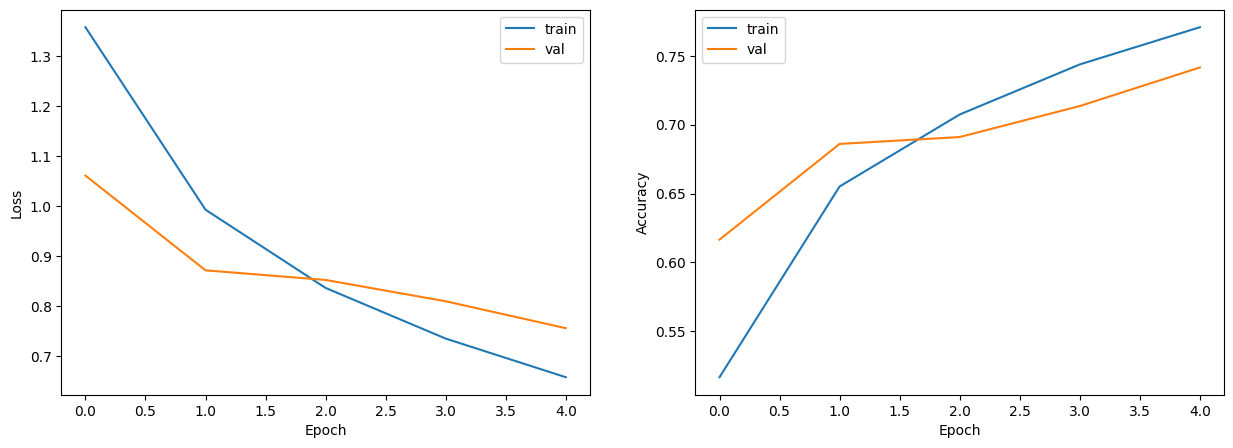

In [ ]:
# Loss curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.plot(metrics["train"]["loss"], label="train")
ax.plot(metrics["val"]["loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = axes[1]
ax.plot(metrics["train"]["accuracy"], label="train")
ax.plot(metrics["val"]["accuracy"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

plt.show()

In [ ]:
# Evaluation - Accuracy
model.load_state_dict(torch.load(results_dir/"best.pth", weights_only=True))
model.eval()

acc = Accuracy(task="multiclass", num_classes=10)
acc = acc.to(device)

acc_per_cls = Accuracy(task="multiclass", num_classes=10, average=None)
acc_per_cls = acc_per_cls.to(device)

confmat = ConfusionMatrix(task="multiclass", num_classes=10)
confmat = confmat.to(device)

test_loss = 0
test_preds = []
test_labels = []
for batch in tqdm(dataloader_test):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        logits = model(images)
        loss = criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)

        acc.update(preds, labels)
        acc_per_cls.update(preds, labels)
        confmat.update(preds, labels)
        test_loss += loss.item()

        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_loss = test_loss / len(dataloader_test)
test_acc = acc.compute()
acc.reset()
print("(Test)  loss {:.4f}, accuracy {:.4f}".format(test_loss, test_acc))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

100%|██████████| 125/125 [00:01<00:00, 81.14it/s]

(Test)  loss 0.7191, accuracy 0.7510


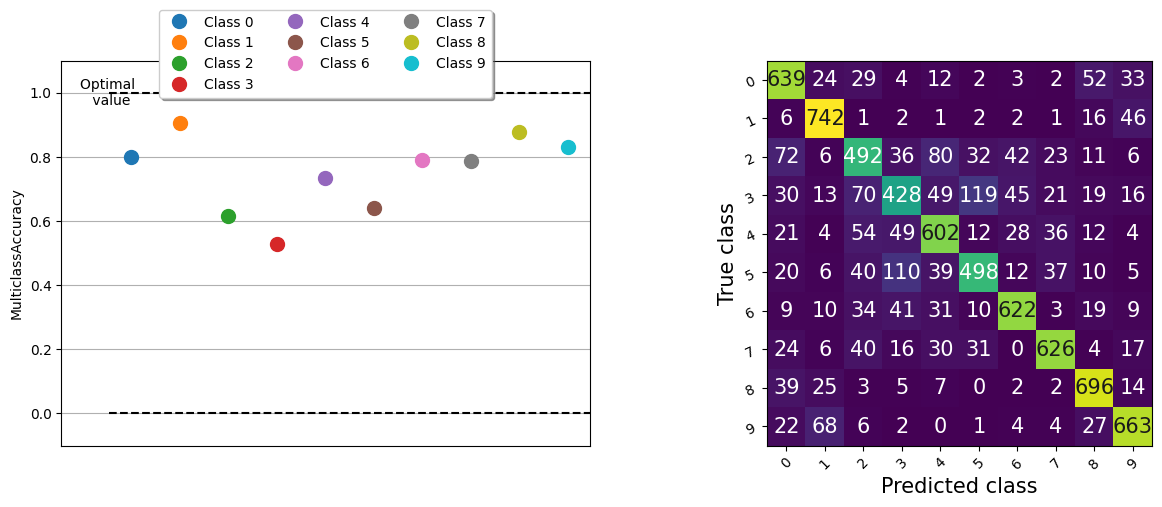

In [ ]:
# Evaluation - Accuracy per class, Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
acc_per_cls.plot(ax=axes[0])
confmat.plot(ax=axes[1])
plt.show()

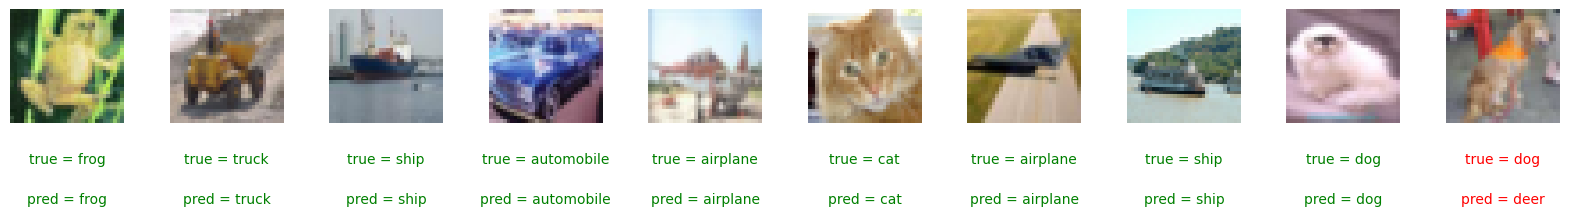

In [ ]:
# Visual evaluation
n_to_show = 10
indices = np.random.choice(range(len(dataset_test)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dataset_test[idx][0].permute(1, 2, 0)
    true_label = id2cls[test_labels[idx]]
    pred_label = id2cls[test_preds[idx]]

    if true_label == pred_label:
        color = "green"
    else:
        color = "red"

    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "true = " + true_label,
        fontsize=10,
        color=color,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "pred = " + pred_label,
        fontsize=10,
        color=color,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)